In [652]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

% matplotlib inline

In [653]:
#Read the data set
loan_df= pd.read_csv('loan.csv', low_memory=False)
dictionaries_df = pd.read_excel('Data_Dictionary.xlsx')

In [654]:
dictionaries_df.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [655]:
# A small function used to get the column description
# Can accept list of columns or a single one
def getColumnDescription(columnNames):
    for column in columnNames:
        print(dictionaries_df[column])

In [656]:
# Get the sample of loan_df data set
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### Lets start with the EDA

#### Briefly we will follow the 5 steps
1. Getting the data
2. Cleaning the data
3. Analyze the data in each of the columns - Univariate analysis
4. Understand how one column affects the other - Bivariate Analysis
5. Check if we could get more data from any of the columns and create a new one - Derived metrics

## 1. Cleaning the data

In [657]:
#Check if any of the columns have total null rows
loan_df.isna().all().sum()

54

In [658]:
# Drop the columns that that have all NaN rows
loan_df.dropna(axis=1, how='all', inplace=True)

In [659]:
# lets get the info of the remaining rows
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
id                            39717 non-null int64
member_id                     39717 non-null int64
loan_amnt                     39717 non-null int64
funded_amnt                   39717 non-null int64
funded_amnt_inv               39717 non-null float64
term                          39717 non-null object
int_rate                      39717 non-null object
installment                   39717 non-null float64
grade                         39717 non-null object
sub_grade                     39717 non-null object
emp_title                     37258 non-null object
emp_length                    38642 non-null object
home_ownership                39717 non-null object
annual_inc                    39717 non-null float64
verification_status           39717 non-null object
issue_d                       39717 non-null object
loan_status                   39717 non-null object
pymnt_pl

In [660]:
loan_df.groupby(by='loan_status').size()

loan_status
Charged Off     5627
Current         1140
Fully Paid     32950
dtype: int64

> ** The status of the loan can be "Charged Off", "Current" or "Fully Paid", since we are only interested in charged-off loans, we will drop the rows containing current and fully paid loans **

In [661]:
loan_df.drop(loan_df[loan_df['loan_status'] != 'Charged Off'].index, inplace=True)

**Since in our analysis we are only concerned on the driving factors for the loans that will be deafulted, we can drop the following columns as well out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, policy_code, application_type, initial_list_status, id, url, desc, emp_title, title**

In [662]:
#drop the columns mentioned above
loan_df.drop(columns=['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                      'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 
                      'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 
                      'initial_list_status', 'id', 'url', 'desc', 'emp_title', 'title'],
            inplace=True)

In [663]:
loan_df['delinq_amnt'].sum()

0

In [664]:
loan_df['acc_now_delinq'].sum()

0

> **Since the rows delinq_amnt, acc_now_delinq contain only zeros, we can remove these two columns as well**

In [665]:
loan_df.groupby(by='pymnt_plan').size()

pymnt_plan
n    5627
dtype: int64

**since all of them have payment plan set as 'n' we can remove this column altogether**

In [666]:
loan_df.drop(columns='pymnt_plan', inplace=True)

**We are done with cleaning of our columns, now we reindex our rows**

In [668]:
# Reset the index of rows
loan_df.reset_index(inplace=True)

In [669]:
loan_df.columns

Index(['index', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens'],
      dtype='object')

In [670]:
loan_df.shape

(5627, 35)

### Univariate Ananlysis

**The fist step that we want to undersatnd here is, which year most of the loans were issued**

In [671]:
#We would be creating a new column altogether, Which year issued the most loans. Formats from http://strftime.org/
loan_df['loan_issue_year'] = pd.to_datetime(loan_df['issue_d'], format='%b-%y').dt.year

Text(0,0.5,'Loan Amount')

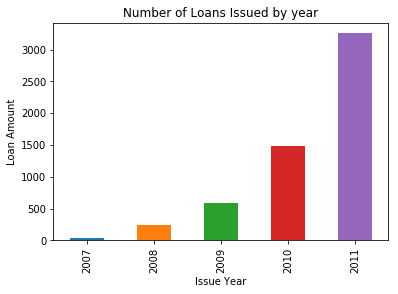

In [676]:
loan_df.groupby(by='loan_issue_year').size().plot(kind='bar')
plt.title("Number of Loans Issued by year")
plt.xlabel("Issue Year")
plt.ylabel("Loan Amount")

> ** From the above analysis, we can see that most loans were issued in the year 2011 **

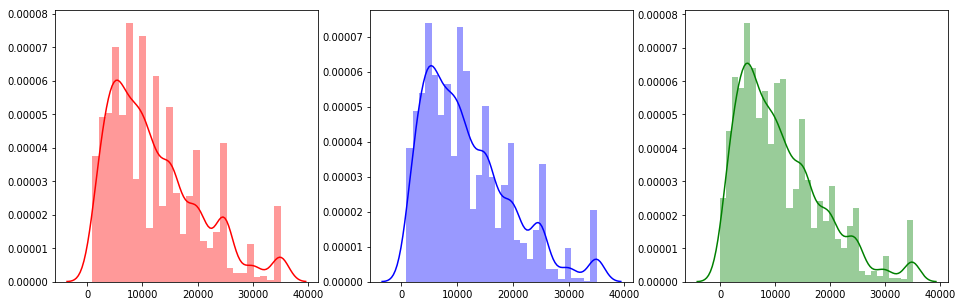

In [677]:
fig, sb_plt = plt.subplots(1, 3, figsize=(16,5))
loan_amount = loan_df['loan_amnt'].values
funded_amount = loan_df['funded_amnt'].values
funded_amount_by_investors = loan_df['funded_amnt_inv'].values
sns.distplot(loan_amount, ax=sb_plt[0], color='r')
sns.distplot(funded_amount, ax=sb_plt[1], color='b')
sns.distplot(funded_amount_by_investors, ax=sb_plt[2], color='g')

**Number of loans that were charged off by state**

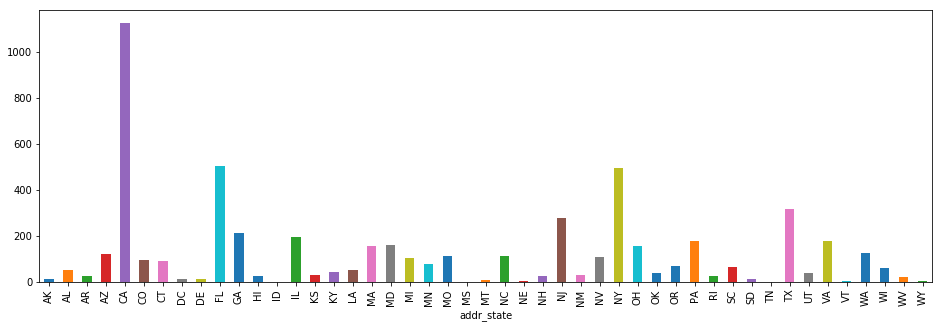

In [678]:
plt.subplots(1, 1, figsize=(16,5))
loan_df.groupby(loan_df['addr_state']).size().plot(kind='bar')

> **We can see that from region CA, maximum loans were deafulted**

In [681]:
for column in loan_df.columns:
    percentage_of_missing_rows = sum(loan_df[column].isna())/5627 * 100
    if(percentage_of_missing_rows > 50):
        print(column)

mths_since_last_delinq
mths_since_last_record


### Q. Are there any members who have taken loans more than once

In [533]:
loan_df.duplicated().sum()

0

> ##### None of the members have taken loans more than once

### Q. Did all of the members had their income verified by LC or if the income source was verified

In [682]:
# lets check if there are any missing values in this column
loan_df['verification_status'].isna().sum()

0

In [683]:
#Lets check the verification_status available
loan_df.groupby(by='verification_status').size()

verification_status
Not Verified       2142
Source Verified    1434
Verified           2051
dtype: int64

**The 'verification_status' of loans can be 'Not Verified', 'Source Verified' and 'Verified'**

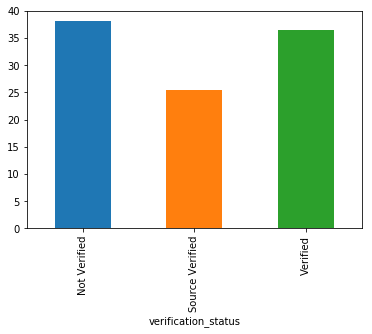

In [687]:
#Lets plot it in a graph 
(loan_df.groupby(by='verification_status').size()/5627 * 100).plot(kind='bar')

> ** From the above graph we can tell that there are more than 35% of the people, whose source is not verified**

### Q. The Charged off loan borrowers term information

In [538]:
loan_df.groupby(by='term').size()

term
 36 months    3227
 60 months    2400
dtype: int64

> ** Most of the loan borrowers have taken loan for either 36 months or 60 months, this dosent provide much information to us, so we will be dropping this column as well**

In [688]:
loan_df.drop(columns='term', inplace=True)

## Q. What is emp_length of the borrowers who are Charged Off

In [689]:
loan_df.groupby(by='emp_length').size()

emp_length
1 year        456
10+ years    1331
2 years       567
3 years       555
4 years       462
5 years       458
6 years       307
7 years       263
8 years       203
9 years       158
< 1 year      639
dtype: int64

## Home ownership details

In [690]:
loan_df.groupby(by='home_ownership').size()

home_ownership
MORTGAGE    2327
OTHER         18
OWN          443
RENT        2839
dtype: int64

> ** Looks like most of the borrowers are either on mortgage or on rent**

## Annual increment details of the borrowers

In [691]:
loan_df['annual_inc']

0        30000.0
1        40000.0
2        15000.0
3        30000.0
4       100000.0
5       105000.0
6        76000.0
7        60000.0
8        50004.0
9       100000.0
10       80000.0
11       50000.0
12       50000.0
13       45996.0
14       30000.0
15       75000.0
16       75000.0
17       45000.0
18       25000.0
19       38000.0
20       75000.0
21       67000.0
22       45000.0
23       52000.0
24       90000.0
25       41000.0
26       42000.0
27       60000.0
28       25000.0
29       85000.0
          ...   
5597     44000.0
5598     40000.0
5599     44400.0
5600     12000.0
5601    616000.0
5602     51000.0
5603    275000.0
5604    120000.0
5605    109000.0
5606     75000.0
5607     85000.0
5608     60000.0
5609     35000.0
5610     39000.0
5611     29120.0
5612     12500.0
5613     10000.0
5614     45600.0
5615     39000.0
5616     62200.0
5617     70000.0
5618     96000.0
5619     15000.0
5620     96000.0
5621     40000.0
5622     32000.0
5623     75000.0
5624    213000

In [544]:
## TODO : annual_inc
loan_df['annual_inc']
sns.boxplot


0

## Q. Why did most of the borrowers took the money for

In [692]:
loan_df['purpose'].isna().any()

False

In [546]:
loan_df.groupby(by='purpose').size()

purpose
car                    160
credit_card            542
debt_consolidation    2767
educational             56
home_improvement       347
house                   59
major_purchase         222
medical                106
moving                  92
other                  633
renewable_energy        19
small_business         475
vacation                53
wedding                 96
dtype: int64

## Q. What is the DTI Debt-To-Income Ratio - DTI of borrowers

In [549]:
loan_df['dti'].describe()

count    5627.000000
mean       14.000624
std         6.585577
min         0.000000
25%         9.050000
50%        14.290000
75%        19.290000
max        29.850000
Name: dti, dtype: float64

**The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
**

In [555]:
loan_df.groupby(by='delinq_2yrs').size()

delinq_2yrs
0    4936
1     507
2     130
3      35
4      13
5       3
6       1
7       1
8       1
dtype: int64

In [569]:
# earliest_cr_line https://www.investopedia.com/terms/l/lineofcredit.asp
loan_df['earliest_cr_line']
temp = pd.to_datetime(loan_df['earliest_cr_line'], format='%b-%y').dt.year
temp.groupby(temp).size()

earliest_cr_line
1969      3
1970      7
1971      5
1972      8
1973     12
1974      6
1975      9
1976      4
1977     13
1978     23
1979     31
1980     16
1981     20
1982     32
1983     53
1984     49
1985     66
1986     53
1987     77
1988    106
1989    112
1990    125
1991    143
1992    135
1993    195
1994    275
1995    303
1996    299
1997    374
1998    415
1999    442
2000    500
2001    356
2002    255
2003    225
2004    229
2005    239
2006    224
2007    144
2008     28
2062      2
2063      1
2065      1
2066      2
2067      5
2068      5
Name: earliest_cr_line, dtype: int64

In [570]:
## open_acc
loan_df['open_acc']

0        3
1       11
2        2
3        4
4       14
5        7
6        7
7        7
8       14
9       17
10       9
11      11
12       7
13       7
14       7
15       6
16       9
17      13
18       7
19       6
20       9
21       6
22      12
23      10
24       9
25       8
26       8
27       8
28       7
29       8
        ..
5597     4
5598     5
5599    15
5600     4
5601    12
5602     8
5603     4
5604    27
5605     6
5606    14
5607    15
5608     9
5609     7
5610     6
5611     3
5612     3
5613     5
5614     3
5615     9
5616     8
5617    15
5618     5
5619    16
5620     4
5621    13
5622    11
5623     9
5624    11
5625     9
5626    17
Name: open_acc, Length: 5627, dtype: int64

In [577]:
# pub_rec very important
sum(loan_df['pub_rec'] == 2)

10

In [642]:
#chargeoff_within_12_mths : Number of charge-offs within 12 months
sum(loan_df['chargeoff_within_12_mths'] ==0)

5621

In [602]:
#Number of public record bankruptcies
(loan_df['pub_rec_bankruptcies'] >= 1).sum()

368

In [610]:
#Tax lein https://www.forbes.com/sites/jaredhecht/2018/08/29/what-is-a-tax-lien-and-how-does-it-affect-your-financing-options/#207e2f31687d
loan_df['tax_liens'].fillna(value=0.0, inplace=True)
sum(loan_df['tax_liens'] == 0.0)

5627